## Content

1. Importing the required libraries
2. Loading and understanding the data
3. Analysis of the data and missing value treatment:Used imputation technique such as iterative imputer
4. Visualizing the data
5. Feature Engineering (Creating new features)
6. Outlier Analysis
7. Train-Test split
8. Scaling
9. Model Building and Evaluation
    - Logistic Regression
    - Random Forest
10. Submission

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Importing libraries

In [2]:
#Data Analysis
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline


#For missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#Warnings
import warnings
warnings.filterwarnings('ignore')

#Preprocessing
from sklearn import preprocessing

#Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


#Machine learning 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

#Random forest
from sklearn.ensemble import RandomForestClassifier


#Vif
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 2. Loading and Data Understanding

In [3]:
# Lets import the train and test data and look into it

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
test_valid = pd.read_csv("test.csv")

merged = [train_df, test_df]

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Looking into the datatype and count 

train_df.info()
print('-'*50)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0  

#### Let's Gain some understanding

Since this is a past event and many of us know about titanic<br>
Accordingly the main criteria for survival would be 
1. Age
2. Passenger's Class 
3. Sex

In [5]:
#Statistical Summary for numeric columns

train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
#Statistical Summary for object columns columns

train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Stankovic, Mr. Ivan",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


In [7]:
# Shape of dataset

print("Size of training data:{0}".format(train_df.shape))

print("Size of test data:{0}".format(test_df.shape))

Size of training data:(891, 12)
Size of test data:(418, 11)


## 3. Analysis of the data and missing value treatment

In [8]:
# Let's look into the missing value percentage 

print(round(100*(train_df.isnull().sum()/len(train_df)),2))
print('-'*40)
print(round(100*(test_df.isnull().sum()/len(test_df)),2))

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64
----------------------------------------
PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.57
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.24
Cabin          78.23
Embarked        0.00
dtype: float64


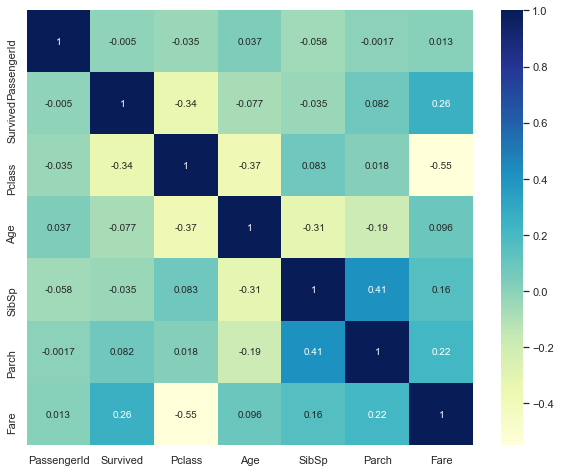

In [9]:
plt.figure(figsize = (10,8))

sns.heatmap(train_df.corr(), annot= True, cmap = 'YlGnBu')

Pclass have negative correlation with Fare i.e. as the fare price increases Pclass is lower

In [10]:
# we will drop Cabin Column from the data has it contain lot of missing values


train_df.drop('Cabin', inplace = True, axis = 1)
test_df.drop('Cabin', inplace = True, axis =1)

In [11]:
# Since we assume that the sex and Pclass is important let's look into the same

# sex
100*pd.crosstab(train_df.Survived, train_df.Sex, margins = True, margins_name = 'Total', normalize = True).round(4)

Sex,female,male,Total
Survived,,,
0,9.09,52.53,61.62
1,26.15,12.23,38.38
Total,35.24,64.76,100.00


Total survival rate is 38.4% out of which 26.2 % is of female

In [12]:
# Cross tabulation to see the M and F distribution across different PClass

100*pd.crosstab(train_df.Sex, train_df.Pclass, margins = True, margins_name = "Total", normalize = True).round(3)

Pclass,1,2,3,Total
Sex,,,,
female,10.5,8.5,16.2,35.2
male,13.7,12.1,38.9,64.8
Total,24.2,20.7,55.1,100.0


Here we can see that major of the population belongs to Passenger Class 3 around 55%<br>
And the ratio of male to female is 13:7

In [13]:
100*pd.crosstab(train_df.Pclass,train_df.Survived, normalize = 'index').round(3)

Survived,0,1
Pclass,,
1,37.0,63.0
2,52.7,47.3
3,75.8,24.2


Passengers belonging to the upper class have the highest rate of survival

In [14]:
# Survival rate of Siblings/Spouses

100*train_df[["SibSp", 'Survived']].groupby(["SibSp"]).mean().sort_values(by = 'Survived', ascending = False).round(4)

,Survived
SibSp,
1,53.59
2,46.43
0,34.54
3,25.00
4,16.67
5,0.00
8,0.00


In [15]:
# Survival rate of Parents/Children

100*train_df[["Parch", 'Survived']].groupby(["Parch"]).mean().sort_values(by = 'Survived', ascending = False).round(4)

,Survived
Parch,
3,60.00
1,55.08
2,50.00
0,34.37
5,20.00
4,0.00
6,0.00


## 4.Visualizing the data

Since our main concern is regarding the Survival we will focusing on it more

Now bucket the age variable into 5 groups defined as: 
- "Age" <= 16: 0
- 16  & <= 32 :1
- 32 & <= 48 :2
- 48 & <= 64 :3
- "Age" > 64 :4

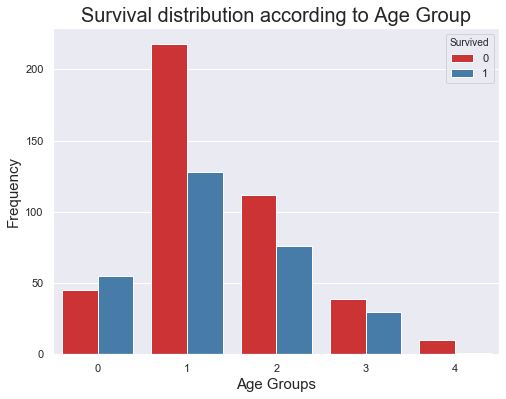

In [16]:
# Visualizing for age group

train_df['Age_Group'] = pd.cut(train_df.Age, bins = [0,16,32,48,64,100], labels = [0,1,2,3,4,])

plt.figure(figsize = (8,6))
sns.countplot('Age_Group', hue = 'Survived', data= train_df, palette="Set1")

plt.title("Survival distribution according to Age Group", fontsize = 20)
plt.ylabel('Frequency',fontsize = 15)
plt.xlabel('Age Groups', fontsize = 15)
plt.show()

We can see that age group of 16-32 has the higest survival rate

In [17]:
# We will drop the age group column has we dont need it

train_df.drop('Age_Group', inplace = True, axis = 1)

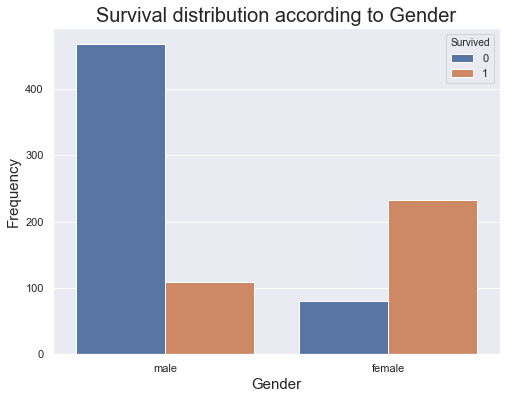

In [18]:
# Visulizing for gender

plt.figure(figsize = (8,6))

sns.countplot('Sex', hue = 'Survived', data= train_df)

plt.title("Survival distribution according to Gender", fontsize = 20)
plt.ylabel('Frequency',fontsize = 15)
plt.xlabel('Gender', fontsize = 15)
plt.show()

Clearly we can see that large number of females survived

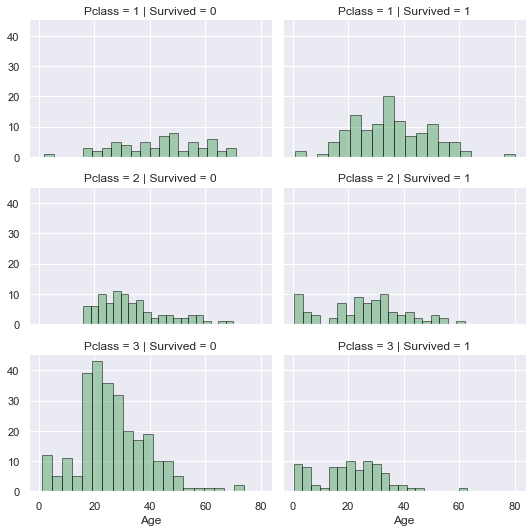

In [19]:
# Visualising for different Pclass

g = sns.FacetGrid(train_df, row = 'Pclass', col = 'Survived', height=2.5, aspect=1.5)
g.map(plt.hist, 'Age', alpha = 0.5, bins = 20,edgecolor="black", color = 'g')

- Most of the Passenger for Pclass 3 didnt survive
- Infants from Pclass 3 and Pclass 2 survived
- Passenegers for Pclass have mostly survived

In [20]:
# we will fill the missing values in embarked with mode

train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace = True)

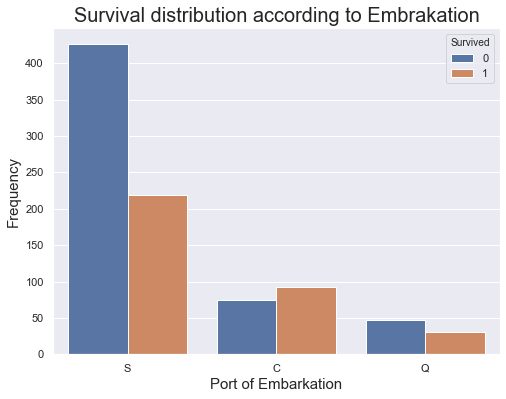

In [21]:
# Visualization for Embrakation

plt.figure(figsize = (8,6))

sns.countplot('Embarked', hue = 'Survived', data = train_df)

plt.title("Survival distribution according to Embrakation", fontsize = 20)
plt.ylabel('Frequency',fontsize = 15)
plt.xlabel('Port of Embarkation', fontsize = 15)
plt.show()


# C = Cherbourg, Q = Queenstown, S = Southampton

- Major of the people are from Southampton, but highest people who didnt surive are also from Southampton

In [22]:
100*pd.crosstab(train_df.Embarked, train_df.Survived, normalize = 'index').round(3)

Survived,0,1
Embarked,,
C,44.6,55.4
Q,61.0,39.0
S,66.1,33.9


- Looking at this we can say that major of the survived people are from Cherbourg 

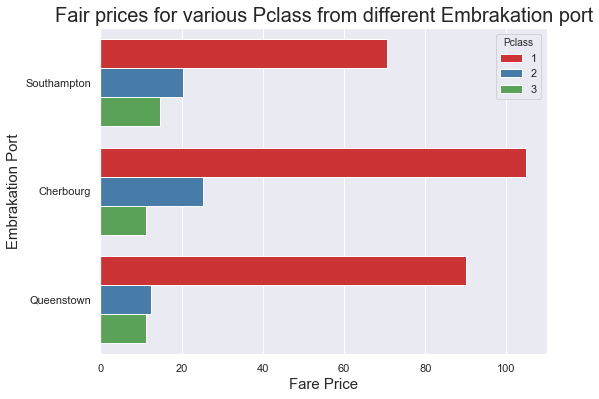

In [23]:
# Let's look into different fare prices for different embarkation port

plt.figure(figsize = (8,6))
sns.barplot(y = 'Embarked', x = 'Fare', data = train_df, hue = 'Pclass', palette = 'Set1', ci = None)

plt.title("Fair prices for various Pclass from different Embrakation port", fontsize = 20)
plt.ylabel('Embrakation Port',fontsize = 15)
plt.yticks([0,1,2], ['Southampton', 'Cherbourg','Queenstown'])
plt.xlabel('Fare Price', fontsize = 15)
plt.show()

- The fair prices are different for different embarkation port
- Cherbourg has the highest number of Passenegers and that to from upper class segment

In [24]:
# Looking into average fair price according to gender and port embarked`

pd.pivot_table(train_df, index = ['Sex','Embarked'], columns = 'Pclass', values = 'Fare', aggfunc = np.mean).round(2)

Pclass                1      2      3
Sex    Embarked                      
female C         115.64  25.27  14.69
       Q          90.00  12.35  10.31
       S          98.27  21.91  18.67
male   C          93.54  25.42   9.35
       Q          90.00  12.35  11.92
       S          52.95  19.23  13.31

- Prices at Cherbourg are maximum with average for Male 93.54 and Female 115.64 dollors

In [25]:
#Checking weather duplicate tickets were issued

duplicate = train_df['Ticket'].duplicated().sum()

print("Number of duplicate tickets issued are {0} which contributes around {1}%".format(duplicate, 100*round(duplicate/len(train_df),2) ))

Number of duplicate tickets issued are 210 which contributes around 24.0%


In [26]:
# Dropping Ticket and Passenger ID from data frame as it doesnt contribute for analysis

train_df.drop(['PassengerId', 'Ticket'], inplace = True, axis = 1)

test_df.drop(['PassengerId', 'Ticket'], inplace = True, axis = 1)

In [27]:
# We will replace male to 1 and female to 0 & make sex column numeric

train_df['Sex'].replace(['female', 'male'], [0,1], inplace = True)
test_df['Sex'].replace(['female','male'], [0,1], inplace = True)

In [28]:
# Label encoding embracked column

le = preprocessing.LabelEncoder()

train_df['Embarked'] = le.fit_transform(train_df['Embarked'])
test_df['Embarked'] = le.fit_transform(test_df['Embarked'])

## 5. Feature Engineering

In [29]:
# We will extract a new feature called Title from name

for df in merged:
    df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand = False)
    
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,0,1
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [30]:
#Replacing the least repeated keywords with others

for df in merged:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Others')
    
    df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
100*pd.crosstab(train_df.Title, train_df.Survived, normalize = 'index').round(3)

Survived,0,1
Title,,
Master,42.5,57.5
Miss,29.7,70.3
Mr,84.3,15.7
Mrs,20.6,79.4
Others,65.2,34.8


In [31]:
# Encoding Title column

for df in merged:
    df['Title'] = le.fit_transform(df['Title'])

In [32]:
# Dropping the Name column from the dataset

for df in merged:
    df.drop('Name', axis = 1, inplace = True)

In [33]:
# Filling the misssing value for fare in test dataset with median

test_df['Fare'].fillna(test_df['Fare'].median(), inplace = True)

In [34]:
# Stroting the column names

train_columns = train_df.columns
test_columns = test_df.columns

In [35]:
# Filling the missing values for age with Iterative Imputer for train

ii = IterativeImputer(initial_strategy='median', min_value = 0, max_value = 80, random_state = 42)

train_df_clean = pd.DataFrame(ii.fit_transform(train_df))
train_df_clean.columns = train_columns

In [36]:
# Similiarly for test

test_df_clean = pd.DataFrame(ii.fit_transform(test_df))
test_df_clean.columns = test_columns

In [37]:
# Restoring the datatype to there original format

main = [train_df_clean, test_df_clean]

for df in main:

    for i in ['Pclass', 'Sex', 'SibSp', 'Parch','Embarked','Title']:
        df[i] = pd.to_numeric(df[i])
        df[i] = df[i].astype(int)

In [38]:
# Changing the datatype of survived in training dataset

train_df_clean['Survived'] = pd.to_numeric(train_df_clean['Survived'])
train_df_clean['Survived'] = train_df_clean['Survived'].astype(int)

In [39]:
train_df_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,2,2
1,1,1,0,38.0,1,0,71.2833,0,3
2,1,3,0,26.0,0,0,7.9250,2,1
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,2,2


In [40]:
# Creating a new feature called 'Familysize'

for df in main:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [41]:
# Family size and surival chances

100 * pd.pivot_table(data = train_df_clean, index = 'FamilySize', values = 'Survived', aggfunc = np.mean).sort_values(by = 'Survived', ascending = False).round(3)

,Survived
FamilySize,
4,72.4
3,57.8
2,55.3
7,33.3
1,30.4
5,20.0
6,13.6
8,0.0
11,0.0


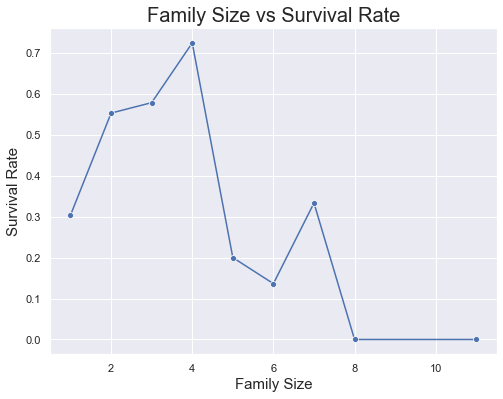

In [42]:
#plotting graph to see surival rate and family size

plt.figure(figsize = (8,6))

sns.lineplot(data = train_df_clean, x = 'FamilySize', y = 'Survived',ci = None, marker="o")

plt.title("Family Size vs Survival Rate", fontsize = 20)
plt.ylabel('Survival Rate',fontsize = 15)
plt.xlabel('Family Size', fontsize = 15)
plt.show()

- We note that family size of 4 has highest survival rate whereas family greater than 8 has 0% survival rate

In [43]:
# Creating another attribute called Is_alone

for df in main:
    df['Is_Alone'] = 0
    df.loc[df['FamilySize']==1, 'Is_Alone'] = 1
    
# 1 = alone & 0 = Not_alone

In [44]:
# Let's look at survival rate of alone passaneger

100 * pd.crosstab(train_df_clean['Is_Alone'], train_df_clean['Survived'], normalize = 'index').round(3)

Survived,0,1
Is_Alone,,
0,49.4,50.6
1,69.6,30.4


- Survival rate of solo passeneger if 30.4%
- Survival rate of family is 50.6%

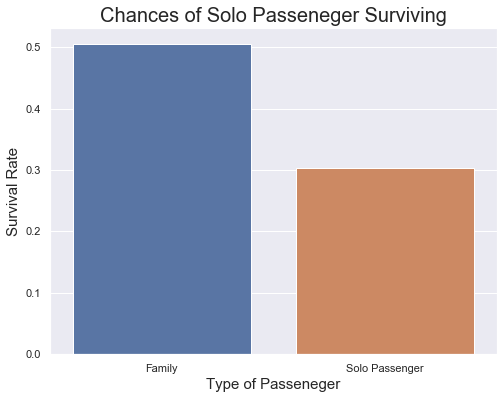

In [45]:
plt.figure(figsize = (8,6))

sns.barplot(data = train_df_clean, x = 'Is_Alone', y = 'Survived', ci = None)

plt.title("Chances of Solo Passeneger Surviving", fontsize = 20)
plt.ylabel('Survival Rate',fontsize = 15)
plt.xlabel('Type of Passeneger', fontsize = 15)
plt.xticks([0,1], ['Family', 'Solo Passenger'])
plt.show()

- Here we can clearly see that the chances of solo passeneger survival is very low comapred to a family

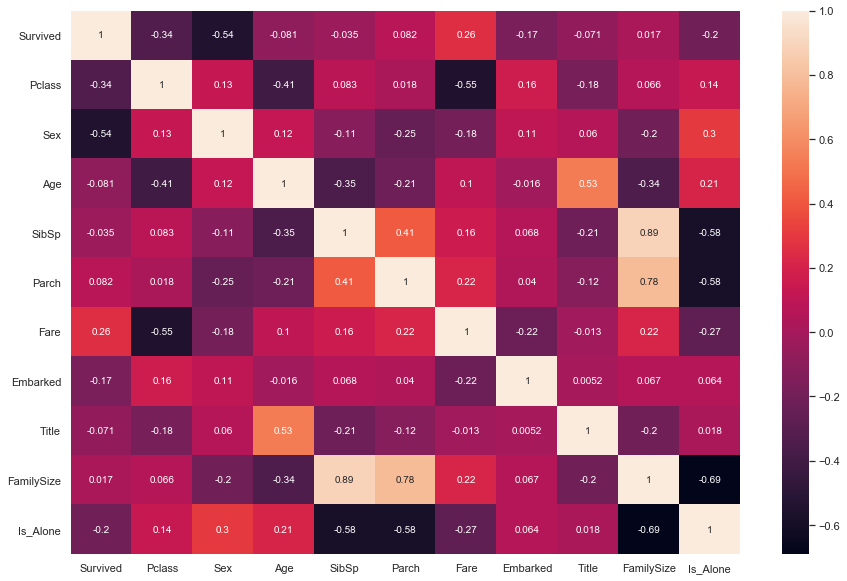

In [46]:
plt.figure(figsize = (15,10))

sns.heatmap(train_df_clean.corr(), annot = True)

In [47]:
# based on the above correaltion we will drop SibSp, Parch, Family_size

for df in main:
    df.drop(['SibSp','Parch','FamilySize'], inplace = True, axis =1)

## 6. Outlier Analysis

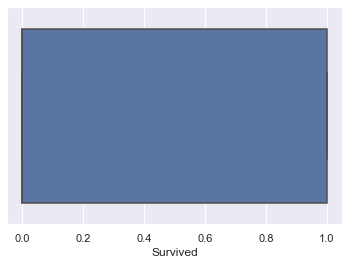

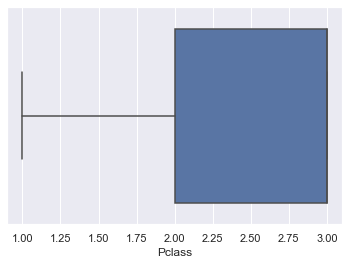

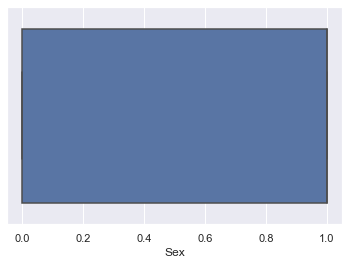

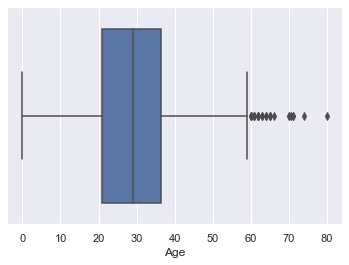

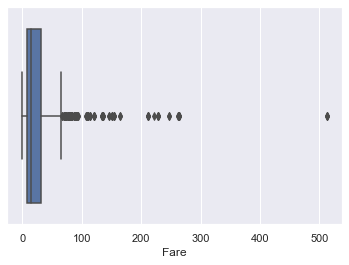

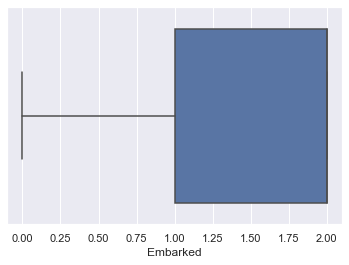

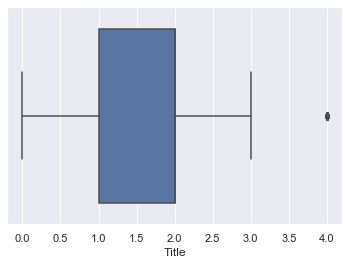

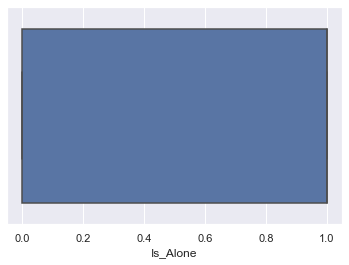

In [48]:
# Plotting box plot for all the variables and checking for outliers


plt.figure

for i, col in enumerate(train_df_clean.columns):
    plt.figure(i)
    sns.boxplot(train_df_clean[col])

In [49]:
# Doing small outlier treatment for fare attribute

train_df_clean.drop(train_df_clean.index[train_df_clean['Fare'] > 300], inplace = True)

**This are the final data frame**

In [50]:
# This are the final data frame

train_df_clean.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Is_Alone
0,0,3,1,22.0,7.2500,2,2,0
1,1,1,0,38.0,71.2833,0,3,0
2,1,3,0,26.0,7.9250,2,1,1
3,1,1,0,35.0,53.1000,2,3,0
4,0,3,1,35.0,8.0500,2,2,1


In [51]:
test_df_clean.head()

,Pclass,Sex,Age,Fare,Embarked,Title,Is_Alone
0,3,1,34.5,7.8292,1,2,1
1,3,0,47.0,7.0000,2,3,0
2,2,1,62.0,9.6875,1,2,1
3,3,1,27.0,8.6625,2,2,1
4,3,0,22.0,12.2875,2,3,0


In [52]:
# Let's look into class imbalance of our target varaible i.e. survived

pd.crosstab(train_df_clean['Survived'], train_df_clean['Survived'], normalize = True).round(4)*100

Survived,0,1
Survived,,
0,61.82,0.00
1,0.00,38.18


- To look at this we have slight class imbalance, we will handle this later using ``weight of class`` method while building model

## 7. Train-Test split

In [53]:
X_train = train_df_clean.drop('Survived', axis =1)

y_train = train_df_clean['Survived']

X_test = test_df_clean

In [54]:
# Storing the column names  for train and test
X_train_col = X_train.columns

X_test_col = X_test.columns

In [55]:
# We will convert the data into array as it will optimize more

X_train, y_train = np.array(X_train), np.array(y_train)

## 8. Scaling

In [56]:
scaler = MinMaxScaler()

#for train data set
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = X_train_col)

In [57]:
#Scaling test dataset

X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns = X_test_col)

In [58]:
#To use later for random forest

rf_X_train = X_train.copy()
rf_X_test = X_test.copy()

**We will build 2 models:**
1. Logestic Regression
2. Random Forest

## Modeling Builidng and Evaluation

## 1. Logistic Regression

In [59]:
# Finding the optimum hyper paramters

## Different parameters to check
max_iter=[100,110,120,130,140]
C_param_range = [0.001,0.01,0.1,1,10,100]
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

## Setting the paramters
param_grid = dict(max_iter = max_iter, C = C_param_range)

## Setting model
log = LogisticRegression(penalty = 'l2')

## Set up GridSearch for score metric

grid_search = GridSearchCV(estimator = log, param_grid = param_grid, cv = folds, n_jobs = -1, 
                           return_train_score = True, scoring = 'accuracy')

## Fitting
grid_search.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 110, 120, 130, 140]},
             return_train_score=True, scoring='accuracy')

In [60]:
# Looking at the best parameters

print("The best accuracy score is {0:2.3} at {1}".format(grid_search.best_score_, grid_search.best_params_))

The best accuracy score is 0.799 at {'C': 10, 'max_iter': 100}


In [61]:
# Setting model with optimum parameters

log = LogisticRegression(penalty = 'l2', C = 10, max_iter =100, class_weight = 'balanced')

In [62]:
# Fitting the model

log_fit = log.fit(X_train, y_train)

In [63]:
# Predicting on test data set

y_test_pred = log_fit.predict(X_test)

In [64]:
#Accuracy score for training data

print("Accuracy score for training data is: {0}".format(round(log_fit.score(X_train, y_train) * 100, 2)))

Accuracy score for training data is: 79.95


#### Looking into p-values and vif and selecting the appropriate features for our model
**NOTE**: This method will reduce the features in our model, I am just trying it out to see if this results in better accuracy

In [65]:
X_train_sm = sm.add_constant(X_train)
log_sm = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = log_sm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  888
Model:                            GLM   Df Residuals:                      880
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -393.12
Date:                Sun, 28 Jun 2020   Deviance:                       786.24
Time:                        16:39:32   Pearson chi2:                     940.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5818      0.504      9.100      0.0

- We can that we have high p-values for Fare, Title and Is_Alone

In [66]:
X_train.shape[1]

7

In [67]:
# Make a VIF dataframe for all the variables present

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range (X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif.reset_index(drop = True, inplace = True)
vif

,Features,VIF
0,Age,9.11
1,Title,8.77
2,Embarked,4.43
3,Pclass,3.66
4,Sex,3.19
5,Is_Alone,3.16
6,Fare,1.74


- Title and Age have high VIF

In [68]:
# Based on the above values we will drop Title

X_train.drop('Title', axis = 1, inplace = True)

In [69]:
X_train_sm = sm.add_constant(X_train)
log_sm = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = log_sm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  888
Model:                            GLM   Df Residuals:                      881
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -393.26
Date:                Sun, 28 Jun 2020   Deviance:                       786.51
Time:                        16:39:32   Pearson chi2:                     941.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5206      0.490      9.230      0.0

- We have high p-values for age and and Is_alone

In [70]:
# Make a VIF dataframe for all the variables present

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range (X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif.reset_index(drop = True, inplace = True)
vif

,Features,VIF
0,Age,4.82
1,Embarked,4.36
2,Pclass,3.29
3,Sex,3.19
4,Is_Alone,3.13
5,Fare,1.70


- All the VIF values are less than 5 and are in the moderate range

In [71]:
# Based on the observation we will drop Is_alone

X_train.drop('Is_Alone', axis =1, inplace = True)

In [72]:
X_train_sm = sm.add_constant(X_train)
log_sm = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = log_sm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  888
Model:                            GLM   Df Residuals:                      882
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -393.33
Date:                Sun, 28 Jun 2020   Deviance:                       786.65
Time:                        16:39:32   Pearson chi2:                     945.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5489      0.484      9.395      0.0

In [73]:
# Make a VIF dataframe for all the variables present

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range (X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif.reset_index(drop = True, inplace = True)
vif

,Features,VIF
0,Embarked,4.35
1,Age,4.07
2,Pclass,3.18
3,Sex,2.99
4,Fare,1.63


- We eill drop Fare has it had p-value greater than 0.05

In [74]:
#Dropping Fare

X_train.drop('Fare', inplace = True, axis =1)

In [75]:
X_train_sm = sm.add_constant(X_train)
log_sm = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = log_sm.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  888
Model:                            GLM   Df Residuals:                      883
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -394.89
Date:                Sun, 28 Jun 2020   Deviance:                       789.78
Time:                        16:39:33   Pearson chi2:                     931.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0741      0.396     10.300      0.0

In [76]:
# Make a VIF dataframe for all the variables present

vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range (X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif.reset_index(drop = True, inplace = True)
vif

,Features,VIF
0,Embarked,4.23
1,Age,3.38
2,Sex,2.98
3,Pclass,2.97


- All the p-values and VIF are less and we will procceed with this now for our predictions

In [77]:
#Prediciting the values of X train

y_train_pred = res.predict(sm.add_constant(X_train))

In [78]:
y_train_pred_final = pd.DataFrame({'Survived': y_train, 'Survived_Proab':y_train_pred})
y_train_pred_final['Survived_Proab'] = round(y_train_pred_final['Survived_Proab'],2)
y_train_pred_final.head(2)

,Survived,Survived_Proab
0,0,0.10
1,1,0.93


In [79]:
# ROC function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [80]:
#Storing the values for FPR, TPR and thersolds

fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final['Survived'], y_train_pred_final['Survived_Proab'], drop_intermediate = False )

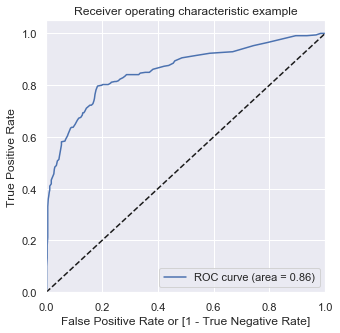

In [81]:
# Call the ROC function

draw_roc(y_train_pred_final['Survived'], y_train_pred_final['Survived_Proab'])

In [82]:
# Let's create columns with different probability cutoffs 

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final['Survived_Proab'].map(lambda x: 1 if x > i else 0)
y_train_pred_final.head(2)

,Survived,Survived_Proab,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.10,1,0,0,0,0,0,0,0,0,0
1,1,0.93,1,1,1,1,1,1,1,1,1,1


In [83]:
# Let's create a dataframe to see the values of accuracy, sensitivity, and specificity at different values of probabiity cutoffs

cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final['Survived'], y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.381757  1.000000  0.000000
0.1   0.1  0.608108  0.923304  0.413479
0.2   0.2  0.713964  0.849558  0.630237
0.3   0.3  0.769144  0.823009  0.735883
0.4   0.4  0.808559  0.796460  0.816029
0.5   0.5  0.799550  0.699115  0.861566
0.6   0.6  0.806306  0.634218  0.912568
0.7   0.7  0.782658  0.489676  0.963570
0.8   0.8  0.751126  0.359882  0.992714
0.9   0.9  0.685811  0.182891  0.996357


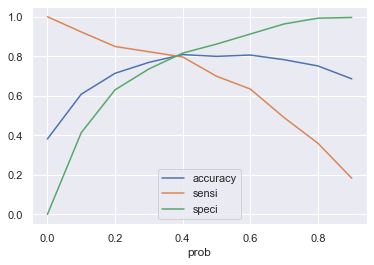

In [84]:
# Plotting sensitivity, accuracy and specificity

sns.set()
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

- Looking at this we can say 0.4 is the optimum threshold point

In [85]:
#Creating final predicated column

y_train_pred_final['final_predicted'] = y_train_pred_final['Survived_Proab'].map( lambda x: 1 if x > 0.4 else 0)

y_train_pred_final.head(2)

,Survived,Survived_Proab,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.10,1,0,0,0,0,0,0,0,0,0,0
1,1,0.93,1,1,1,1,1,1,1,1,1,1,1


In [86]:
#Looking into the accuray of training data set

print("Accuracy : {:2.2}".format(metrics.accuracy_score(y_train_pred_final['Survived'], y_train_pred_final['final_predicted'])))

Accuracy : 0.81


#### Making predictions on Test data

In [87]:
# Drop the required columns from X_test as well

X_test.drop(['Fare', 'Is_Alone', 'Title'], axis =1, inplace = True)

In [88]:
# Making predictions on test data set

y_test_pred1 = res.predict(sm.add_constant(X_test))

In [89]:
# Converting y_pred to a dataframe

y_pred1 = pd.DataFrame(y_test_pred1, columns = ['Survived_Proab'])
y_pred1.reset_index(drop = True, inplace = True)
y_pred1

,Survived_Proab
0,0.072736
1,0.322565
2,0.081590
3,0.076713
4,0.564620
...,...
413,0.076832
414,0.925388
415,0.049795
416,0.076832


In [90]:
# Make predictions on the test set using 0.4 as the cutoff

y_pred1['final_predicted'] = y_pred1['Survived_Proab'].map(lambda x: 1 if x > 0.4 else 0)
y_pred1.head()

,Survived_Proab,final_predicted
0,0.072736,0
1,0.322565,0
2,0.081590,0
3,0.076713,0
4,0.564620,1


In [91]:
#Top features and there importance

IP = pd.DataFrame(res.params , columns = ['Importance'])
IP.reset_index(inplace = True)
IP.columns = ['Features', 'Importance']
IP.drop(IP.index[0], inplace = True)
IP = IP.sort_values(by = 'Importance')
IP.reset_index(drop = True, inplace =True)
IP['Importance'] =  round(IP['Importance'], 2)
IP.head(10)

,Features,Importance
0,Age,-3.04
1,Sex,-2.55
2,Pclass,-2.45
3,Embarked,-0.49


## Random Forest

In [92]:
# Instantiate

rf = RandomForestClassifier()

#Fitting 
rf.fit(rf_X_train, y_train)

RandomForestClassifier()

In [93]:
# Setting up folds
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

#Setting up parameters to check
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [4,5,6,7]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = folds, n_jobs = -1,verbose = 1)

In [94]:
# Fit the grid search to the data

grid_search.fit(rf_X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 8, 10], 'max_features': [4, 5, 6, 7],
                         'min_samples_leaf': range(100, 400, 200),
                         'min_samples_split': range(200, 500, 200),
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [95]:
# printing the optimal accuracy score and hyperparameters

print('We can get accuracy of',round(grid_search.best_score_,2),'using',grid_search.best_params_)

We can get accuracy of 0.79 using {'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200}


In [96]:
# model with the best hyperparameters

rf = RandomForestClassifier(bootstrap=True,class_weight = "balanced", criterion = 'gini',
                             max_depth=4,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=4,
                             n_estimators=200)
rf_fit = rf.fit(rf_X_train, y_train)

In [97]:
#Predicitng on test

rf_y_pred_test = rf_fit.predict(rf_X_test)

## 10. Submission

In [98]:
#File submission

submission = pd.DataFrame({"PassengerId": test_valid["PassengerId"], "Survived": rf_y_pred_test})

submission.to_csv('submission_.csv', index=False)